In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import itertools 

In [0]:
np.random.seed(123) # for reproducibility

# Color Transfer (Global Matching Algorithm)

This notebook is used to implement the algorithm proposed by [Welsh](https://www3.cs.stonybrook.edu/~mueller/research/colorize/colorize-sig02.pdf) in 2002. Here, we implemented global image matching algorithm first. In this algorithm, we would samples 200 pixels from source image. Then for each pixel in the grayscale image, we would find their best matching pixel in the source samples based on weighted average of neighbourhood statistic (50%) and lumniance (50%). Finally, we would use the ab value of the best matching pixel to colorize our grayscale image pixel by pixel. 

## Step 0: Read images

Images used in this implementation are 258(width)*168(height). 

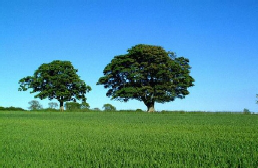

In [0]:
source_image_path = 'source.jpg'
source_image = Image.open(source_image_path)
source_image

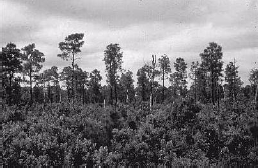

In [0]:
target_image_path = 'target.jpg'
target_image = Image.open(target_image_path)
target_image

## Step 1: BGR to LAB

In [0]:
# Note: cv2 would read images as BGR 
source_img = cv2.imread('source.jpg')
target_img = cv2.imread('target.jpg',cv2.IMREAD_GRAYSCALE)
source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2LAB)

In [0]:
s_l, s_a, s_b = cv2.split(source_img)
t_l = target_img.copy()

## Step 2: Luminance Remapping

In [0]:
def luminance_remap(source,target):
  """This function will remap luminance for source image
  
  Arguments:
    source: l channel of source image
    target: target image(grayscale image)
   
  Returns:
    returns remapped source image
  """
  
  t_mean = np.mean(target)
  s_mean = np.mean(source)
  t_sd = np.std(target)
  s_sd = np.std(source)
  s_remapped = (t_sd/s_sd)*(source-s_mean)+t_mean
  return s_remapped

In [0]:
s_l_remapped = luminance_remap(s_l,t_l)

## Step 3: Sampling and compute statistics for source image

In [0]:
def compute_stat_jitter_samples(source_l,source_a,source_b,neigh_grid=(5,5),sample_num=200):
  """This function will compute weighted average of luminance and neighbourhood statistics.
  
  Arguments:
    source_l: l channel of source image
    source_a: a channel of source image
    source_b: b channel of source image
    neigh_grid: grid size of neighbourhood(tuple)
    sample_num: numbers of sample
   
  Returns:
    returns weighted average statistics
  """
  
  samples_stat = np.zeros(sample_num)
  coors_list = np.asarray(list((itertools.product(range(source_l.shape[0]),range(source_l.shape[1])))))
  inds = np.random.choice(range(len(coors_list)),sample_num,replace=False)
  coors =coors_list[inds]
  l_values = [source_l[coors[i,0]][coors[i,1]] for i in range(sample_num)]
  a_values = [source_a[coors[i,0]][coors[i,1]] for i in range(sample_num)]
  b_values = [source_b[coors[i,0]][coors[i,1]] for i in range(sample_num)]
  ab_lst = [i for i in zip(a_values,b_values)]
  # compute neighbourhood standard deviation
  for idx, coor in enumerate(coors):
    x,y = coor[0],coor[1]
    x_lower, x_upper = x-neigh_grid[0]//2, x+neigh_grid[0]//2+1
    y_lower, y_upper = y-neigh_grid[1]//2, y+neigh_grid[1]//2+1
    # bound control
    x_lower = max(x_lower,0)
    y_lower = max(y_lower,0)
    std_value = np.std(source_l[x_lower:x_upper,y_lower:y_upper])
    samples_stat[idx] = l_values[idx]*0.5+0.5*std_value
  
  return samples_stat, np.asarray(ab_lst) 

In [0]:
s_samples_stats, s_ab_lst=compute_stat_jitter_samples(s_l,s_a,s_b,neigh_grid=(5,5),sample_num=200)

## Step 4: Colorize for grayscale target

In [0]:
def find_best_match(samples_stats,target_stat):
  """This function will find the best matching pixel in source samples for target pixels
  
  Arguments:
    samples_stats: statistics for source samples 
    target_stat: statistic for a single target pixel
   
  Returns:
    returns the best matching pixel index
  """
  
  return np.argmin(np.square(samples_stats-target_stat))

In [0]:
def color_transfer(target_l,samples_stats,samples_ab,neigh_grid=(5,5)):
  """This function will transfer color for a grayscale image
  
  Arguments:
    target_l: l channel of target image
    samples_stats: statistics of source samples
    samples_ab: ab values list of source samples
    neigh_grid: grid size of neighbourhood(tuple)
   
  Returns:
    returns colorized target image(RGB)
  """
  
  target_a = []
  target_b = []
  for x in range(target_l.shape[0]):
    for y in range(target_l.shape[1]):
      x_lower, x_upper = x-neigh_grid[0]//2, x+neigh_grid[0]//2+1
      y_lower, y_upper = y-neigh_grid[1]//2, y+neigh_grid[1]//2+1
      # bound control
      x_lower = max(x_lower,0)
      y_lower = max(y_lower,0)
      std_value = np.std(target_l[x_lower:x_upper,y_lower:y_upper])
      target_stat = 0.5*target_l[x,y]+0.5*std_value
      idx = find_best_match(samples_stats,target_stat)
      target_a.append(samples_ab[idx][0])
      target_b.append(samples_ab[idx][1])
  target_a = np.asarray(target_a).reshape(target_l.shape)
  target_b = np.asarray(target_b).reshape(target_l.shape)
  target = cv2.merge([target_l,target_a,target_b])
  target = cv2.cvtColor(target.astype("uint8"), cv2.COLOR_LAB2RGB)
  cv2.imwrite('target_color.jpg',target[:,:,::-1])
  return target

In [0]:
color_image = color_transfer(t_l,s_samples_stats, s_ab_lst,neigh_grid=(5,5))

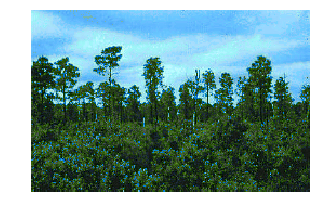

In [0]:
plt.figure(figsize=(5,5))
plt.imshow(color_image)
plt.grid(False)
plt.axis('off')
plt.show()

It seems that this global matching algorithm performs not bad on transferring color from source image to a grayscale image. However, it is not subtle enough. And there is another issue for this algorithm: what if our grayscale image is not so similar to our source image? 

## Drawbacks

In [0]:
target2_origin = cv2.imread('target2_origin.jpg')
target2_img = cv2.imread('target2_gray.jpg',cv2.IMREAD_GRAYSCALE)
color_image2 = color_transfer(target2_img,s_samples_stats, s_ab_lst,neigh_grid=(5,5))

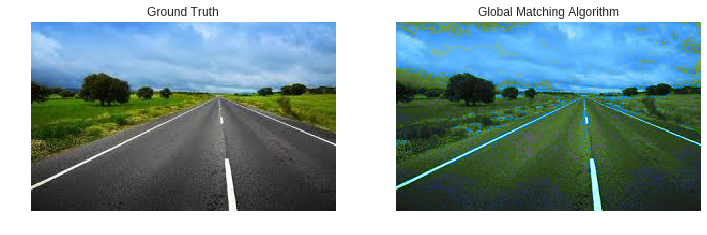

In [0]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(target2_origin[:,:,::-1])
plt.title('Ground Truth')
plt.grid(False)
plt.axis('off')
plt.subplot(122)
plt.imshow(color_image2)
plt.title('Global Matching Algorithm')
plt.grid(False)
plt.axis('off')
plt.show()

In this case, the global matching algorithm cannot perform well——it cannot colorize `road`  which does not show in source image correctly!  In order to solve this problem, welsh in his paper also tried **color transfer using swatches** which introduced human interaction for the global matching algorithm so as to improve results. However, I did not implement this *swatches* algorithm because my goal is to colorize grayscale images automatically rather than with the help of human or users. 

## Summary

Advantages: 
* simple and easy to understand.
* good for similar images. 

Disadvantages: 
* not subtle enough.
* cannot perform well for *different* images.

## References



1.   Welsh Transferring Color to Greyscale Images. 
2.   ColorTransfer(2001).
3.   analogies hertzmann paper.
4.   Welsh slide.

